In [1]:
import numpy as np
import pandas as pd
import time
import os
import re
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ExpW

In [2]:
frame = pd.read_csv('ExpW_OpenFace_result_with_expression_gender_race_age.csv')
frame.head()

,ImageName,Expression,race_preds,gender_preds,age_preds,race_scores,gender_scores,age_scores,face,confidence,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,angry_actor_104_0.jpg,0,Black,Male,20-29,[0.01164725 0.5489195 0.06282789 0.03017501 0...,[0.97893476 0.02106526],[0.00264865 0.03285832 0.07209051 0.29417548 0...,0.0,0.875,...,0.00,0.41,3.61,0.54,1.10,0.68,0.00,2.23,0.00,0.17
1,angry_actor_109_0.jpg,0,Middle Eastern,Male,10-19,[0.07172439 0.03716405 0.07634144 0.09301798 0...,[0.9886888 0.01131118],[5.5791729e-04 2.5763142e-01 4.3460685e-01 2.5...,0.0,0.925,...,1.16,0.76,0.77,1.12,0.04,1.38,0.00,1.20,0.00,0.00
2,angry_actor_120_1.jpg,2,White,Male,20-29,[0.38725546 0.02379545 0.04428627 0.3587341 0...,[0.7577495 0.24225047],[0.00361199 0.02466666 0.0458126 0.62581354 0...,1.0,0.925,...,0.06,0.00,1.51,0.00,0.00,0.00,0.00,1.09,0.51,0.10
3,angry_actor_13_0.jpg,3,East Asian,Female,20-29,[0.05252786 0.06977403 0.0932842 0.40103135 0...,[0.46038443 0.5396156 ],[0.00304344 0.0880671 0.22934933 0.39468738 0...,0.0,0.975,...,0.99,0.00,0.00,0.36,0.56,0.00,0.13,0.96,1.02,0.00
4,angry_actor_132_0.jpg,0,White,Female,20-29,[0.29344454 0.09408408 0.14308809 0.2740257 0...,[0.44868255 0.55131745],[0.00321869 0.0189087 0.0630689 0.40079823 0...,0.0,0.875,...,0.05,0.00,0.13,0.00,0.76,0.00,0.25,0.00,0.06,0.00


In [3]:
frame.loc[frame['Expression'] == 0, 'Expression'] = 'angry'
frame.loc[frame['Expression'] == 1, 'Expression'] = 'disgust'
frame.loc[frame['Expression'] == 2, 'Expression'] = 'fear'
frame.loc[frame['Expression'] == 3, 'Expression'] = 'happy'
frame.loc[frame['Expression'] == 4, 'Expression'] = 'sad'
frame.loc[frame['Expression'] == 5, 'Expression'] = 'surprise'
frame.loc[frame['Expression'] == 6, 'Expression'] = 'neutral'
frame.Expression.value_counts()

neutral     33927
happy       28893
sad         10429
surprise     6880
disgust      3805
angry        3602
fear         1064
Name: Expression, dtype: int64

In [4]:
frame['Angry'] = (frame['Expression'] =='angry').astype(int)
frame['Disgust'] = (frame['Expression'] == 'disgust').astype(int)
frame['Fear'] = (frame['Expression'] == 'fear').astype(int)
frame['Happy'] = (frame['Expression'] =='happy').astype(int)
frame['Sad'] = (frame['Expression'] == 'sad').astype(int)
frame['Surprise'] = (frame['Expression'] == 'surprise').astype(int)
frame['Neutral'] = (frame['Expression'] == 'neutral').astype(int)

In [5]:
frame = frame.dropna()
frame.shape

(85355, 188)

In [6]:
frame.race_preds.value_counts()

East Asian         26409
White              25826
Black              11381
Latino_Hispanic     8751
Middle Eastern      5905
Southeast Asian     5382
Indian              1701
Name: race_preds, dtype: int64

In [7]:
# race label
frame.loc[frame['race_preds'] == 'White', 'race'] = 0
frame.loc[frame['race_preds'] == 'Black', 'race'] = 1
frame.loc[frame['race_preds'] == 'Latino_Hispanic', 'race'] = 2
frame.loc[frame['race_preds'] == 'East Asian', 'race'] = 3
frame.loc[frame['race_preds'] == 'Southeast Asian', 'race'] = 4
frame.loc[frame['race_preds'] == 'Indian', 'race'] = 5
frame.loc[frame['race_preds'] == 'Middle Eastern', 'race'] = 6
frame.race.value_counts()

3.0    26409
0.0    25826
1.0    11381
2.0     8751
6.0     5905
4.0     5382
5.0     1701
Name: race, dtype: int64

In [8]:
frame['Race'] = frame['race_preds'].apply(lambda x: x if x != 'East Asian' and x != 'Southeast Asian' else 'Asian')
frame['Race'] = frame['Race'].apply(lambda x: x if x != 'Latino_Hispanic' else 'Latino-Hispanic')
frame.Race.value_counts()

Asian              31791
White              25826
Black              11381
Latino-Hispanic     8751
Middle Eastern      5905
Indian              1701
Name: Race, dtype: int64

In [9]:
print(list(frame.columns))

['ImageName', 'Expression', 'race_preds', 'gender_preds', 'age_preds', 'race_scores', 'gender_scores', 'age_scores', 'face', 'confidence', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'x_65', 'x_66', 'x_67', 'y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15', 'y_16', 'y_17', 'y_18', 'y_19

# ExpW expression label：
- "0" "angry"
- "1" "disgust"
- "2" "fear"
- "3" "happy"
- "4" "sad"
- "5" "surprise"
- "6" "neutral"

In [10]:
frame.loc[frame['Expression'] == 0, 'Expression'] = 'angry'
frame.loc[frame['Expression'] == 1, 'Expression'] = 'disgust'
frame.loc[frame['Expression'] == 2, 'Expression'] = 'fear'
frame.loc[frame['Expression'] == 3, 'Expression'] = 'happy'
frame.loc[frame['Expression'] == 4, 'Expression'] = 'sad'
frame.loc[frame['Expression'] == 5, 'Expression'] = 'surprise'
frame.loc[frame['Expression'] == 6, 'Expression'] = 'neutral'
frame.Expression.value_counts()

neutral     32384
happy       28252
sad          9853
surprise     6666
disgust      3719
angry        3494
fear          987
Name: Expression, dtype: int64

In [11]:
frame['Angry'] = (frame['Expression'] =='angry').astype(int)
frame['Disgust'] = (frame['Expression'] == 'disgust').astype(int)
frame['Fear'] = (frame['Expression'] == 'fear').astype(int)
frame['Happy'] = (frame['Expression'] =='happy').astype(int)
frame['Sad'] = (frame['Expression'] == 'sad').astype(int)
frame['Surprise'] = (frame['Expression'] == 'surprise').astype(int)
frame['Neutral'] = (frame['Expression'] == 'neutral').astype(int)

In [12]:
frame = frame.dropna()
frame.shape

(85355, 190)

# Using the optimal threshold to re-create the AU presence

In [13]:
AU_intensity_OpenFace_common2 = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU09_r', 'AU10_r', 
                'AU12_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU25_r', 'AU26_r']
optimal_threshold = np.array([4.4, 4.8, 2.4, 3.7, 1.8, 2.8, 0.2, 1.3, 1.3, 5. , 5. , 0.7, 5. ])
for i in range(len(AU_intensity_OpenFace_common2)):
    frame[AU_intensity_OpenFace_common2[i] + "_c"] = frame[AU_intensity_OpenFace_common2[i]].apply(lambda x: 0 if x <= optimal_threshold[i] else 1)

frame.shape

(85355, 203)

In [14]:
print(list(frame.columns))

['ImageName', 'Expression', 'race_preds', 'gender_preds', 'age_preds', 'race_scores', 'gender_scores', 'age_scores', 'face', 'confidence', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'x_65', 'x_66', 'x_67', 'y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13', 'y_14', 'y_15', 'y_16', 'y_17', 'y_18', 'y_19

In [15]:
frame['AU6and12_c'] = frame.AU06_c.apply(int).apply(str) + frame.AU12_c.apply(int).apply(str)
frame.AU6and12_c.value_counts()

00    33062
11    26450
10    15317
01    10526
Name: AU6and12_c, dtype: int64

In [16]:
frame['AU6and12_r_c'] = frame.AU06_r_c.apply(str) + frame.AU12_r_c.apply(str)
frame.AU6and12_r_c.value_counts()

00    61183
01    13396
11     8145
10     2631
Name: AU6and12_r_c, dtype: int64

In [17]:
frame_0 = frame.loc[frame['race'] == 0]
frame_1 = frame.loc[frame['race'] == 1]
frame_2 = frame.loc[(frame['race'] == 3) | (frame['race'] == 4)]
frame_3 = frame.loc[frame['race'] == 5]
frame_4 = frame.loc[frame['race'] == 2]
frame_5 = frame.loc[frame['race'] == 6]
print(frame_0.shape)
print(frame_1.shape)
print(frame_2.shape)
print(frame_3.shape)
print(frame_4.shape)
print(frame_5.shape)

(25826, 205)
(11381, 205)
(31791, 205)
(1701, 205)
(8751, 205)
(5905, 205)


In [18]:
frame_list = [frame_2, frame_1, frame_0, frame_3, frame_4, frame_5]
name_list = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern']

# P(expression|AU1, male) =? P(expression|AU1, female)

## Happiness

In [19]:
for i in range(len(frame_list)):
    print(frame_list[i].Happy.mean(), name_list[i], frame_list[i].shape[0])

0.31939857192287124 Asian 31791
0.3226430014937176 Black 11381
0.32808022922636104 White 25826
0.4056437389770723 Indian 1701
0.39766883784710316 Latino-Hispanic 8751
0.3019475021168501 Middle Eastern 5905


In [20]:
for i in range(len(frame_list)):
    print(frame_list[i].AU06_r_c.mean(), name_list[i], frame_list[i].shape[0])

0.12534994180742978 Asian 31791
0.1339073895088305 Black 11381
0.11732362735228065 White 25826
0.15696649029982362 Indian 1701
0.14958290481087877 Latino-Hispanic 8751
0.11193903471634209 Middle Eastern 5905


In [21]:
for i in range(len(frame_list)):
    print(frame_list[i].AU12_r_c.mean(), name_list[i], frame_list[i].shape[0])

0.24799471548551477 Asian 31791
0.23548018627537123 Black 11381
0.25013552234182607 White 25826
0.284538506760729 Indian 1701
0.3097931664952577 Latino-Hispanic 8751
0.22387806943268418 Middle Eastern 5905


In [22]:
for i in range(len(frame_list)):
    print(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index'), name_list[i], frame_list[i].shape[0])

Happy                0         1
AU6and12_r_c                    
00            0.823013  0.176987
01            0.302925  0.697075
10            0.747475  0.252525
11            0.185309  0.814691 Asian 31791
Happy                0         1
AU6and12_r_c                    
00            0.818742  0.181258
01            0.277284  0.722716
10            0.733333  0.266667
11            0.166667  0.833333 Black 11381
Happy                0         1
AU6and12_r_c                    
00            0.806145  0.193855
01            0.321847  0.678153
10            0.757009  0.242991
11            0.189829  0.810171 White 25826
Happy                0         1
AU6and12_r_c                    
00            0.758176  0.241824
01            0.250000  0.750000
10            0.672727  0.327273
11            0.117925  0.882075 Indian 1701
Happy                0         1
AU6and12_r_c                    
00            0.789574  0.210426
01            0.237113  0.762887
10            0.724696  0.27

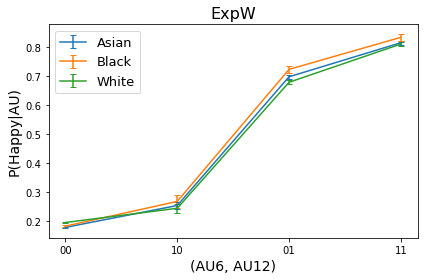

In [23]:
list_00 = []
list_01 = []
list_10 = []
list_11 = []

list_00_n = []
list_01_n = []
list_10_n = []
list_11_n = []

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
for i in range(len(frame_list)-3):
    list_00.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['00',1])
    list_01.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['01',1])
    list_10.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['10',1])
    list_11.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['11',1])
    
    list_00_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['00','All'])
    list_01_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['01','All'])
    list_10_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['10','All'])
    list_11_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['11','All'])
    
result_df = pd.DataFrame({"00": list_00, "10": list_10, "01": list_01, "11": list_11,
                         "00_n": list_00_n, "10_n": list_10_n, "01_n": list_01_n, "11_n": list_11_n}, index = name_list[:-3])
result_df['00_std'] = np.sqrt(result_df['00'] * (1-result_df['00']) / result_df['00_n'])
result_df['10_std'] = np.sqrt(result_df['10'] * (1-result_df['10']) / result_df['10_n'])
result_df['01_std'] = np.sqrt(result_df['01'] * (1-result_df['01']) / result_df['01_n'])
result_df['11_std'] = np.sqrt(result_df['11'] * (1-result_df['11']) / result_df['11_n'])
result_df
for index, row in result_df.iterrows():
    plt.errorbar(list(result_df.columns)[:4], list(row)[:4], yerr = list(row)[8:], label = index, capsize = 3)
plt.legend(fontsize = 13)
plt.xlabel('(AU6, AU12)', fontsize = 14)
plt.ylabel('P(Happy|AU)', fontsize = 14)
plt.title('ExpW', fontsize = 16)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_3_groups_graphs/ExpW_happy_3_all.pdf')
plt.show()

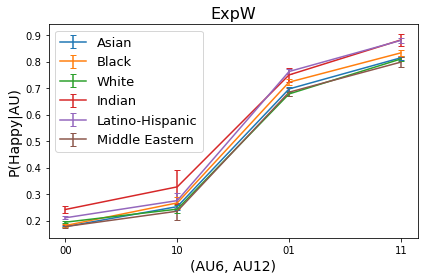

In [24]:
list_00 = []
list_01 = []
list_10 = []
list_11 = []

list_00_n = []
list_01_n = []
list_10_n = []
list_11_n = []

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
for i in range(len(frame_list)):
    list_00.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['00',1])
    list_01.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['01',1])
    list_10.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['10',1])
    list_11.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['11',1])
    
    list_00_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['00','All'])
    list_01_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['01','All'])
    list_10_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['10','All'])
    list_11_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['11','All'])
    
result_df = pd.DataFrame({"00": list_00, "10": list_10, "01": list_01, "11": list_11,
                         "00_n": list_00_n, "10_n": list_10_n, "01_n": list_01_n, "11_n": list_11_n}, index = name_list)
result_df['00_std'] = np.sqrt(result_df['00'] * (1-result_df['00']) / result_df['00_n'])
result_df['10_std'] = np.sqrt(result_df['10'] * (1-result_df['10']) / result_df['10_n'])
result_df['01_std'] = np.sqrt(result_df['01'] * (1-result_df['01']) / result_df['01_n'])
result_df['11_std'] = np.sqrt(result_df['11'] * (1-result_df['11']) / result_df['11_n'])
result_df
for index, row in result_df.iterrows():
    plt.errorbar(list(result_df.columns)[:4], list(row)[:4], yerr = list(row)[8:], label = index, capsize = 3)
plt.legend(fontsize = 13)
plt.xlabel('(AU6, AU12)', fontsize = 14)
plt.ylabel('P(Happy|AU)', fontsize = 14)
plt.title('ExpW', fontsize = 16)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/ExpW_happy_6_all.pdf')
plt.show()

In [25]:
for AU_comb in ['00','10', '01', '11']:
    print(AU_comb)
    combined_df = pd.DataFrame()
    for i in range(len(frame_list)):
        combined_df = combined_df.append(pd.crosstab(frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Race, frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Happy))
    combined_df
    combined_df["row_totals"] = combined_df[0] + combined_df[1]
    combined_df.loc["col_totals"] = combined_df.sum()
    combined_df
    observed = combined_df.iloc[0:-1,0:-1]   # Get table without totals for later use

    expected =  np.outer(combined_df["row_totals"][0:-1],
                     combined_df.loc["col_totals"][0:-1]) / combined_df.loc['col_totals', 'row_totals']

    expected = pd.DataFrame(expected)
    expected.columns = [0,1]
    expected.index = combined_df.index[:-1]

    if (expected>=5).sum().sum() == (combined_df.shape[0]-1) * (combined_df.shape[1]-1):
        chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
        p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df= (combined_df.shape[0]-2) * (combined_df.shape[1]-2))
    else:
        chi_squared_stat = np.nan
        p_value = np.nan

    print(chi_squared_stat)
    print(p_value)
    print()

00
69.29836012543467
1.4344081478157023e-13

10
3.2984364831810766
0.6540810645598973

01
48.59793678009742
2.6813985476437097e-09

11
36.03538319215849
9.344568829838806e-07



In [26]:
# p-value for testing the three major races only
for AU_comb in ['00','10', '01', '11']:
    print(AU_comb)
    combined_df = pd.DataFrame()
    for i in range(3):
        combined_df = combined_df.append(pd.crosstab(frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Race, frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Happy))
    combined_df
    combined_df["row_totals"] = combined_df[0] + combined_df[1]
    combined_df.loc["col_totals"] = combined_df.sum()
    combined_df
    observed = combined_df.iloc[0:-1,0:-1]   # Get table without totals for later use

    expected =  np.outer(combined_df["row_totals"][0:-1],
                     combined_df.loc["col_totals"][0:-1]) / combined_df.loc['col_totals', 'row_totals']

    expected = pd.DataFrame(expected)
    expected.columns = [0,1]
    expected.index = combined_df.index[:-1]

    if (expected>=5).sum().sum() == (combined_df.shape[0]-1) * (combined_df.shape[1]-1):
        chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
        p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df= (combined_df.shape[0]-2) * (combined_df.shape[1]-2))
    else:
        chi_squared_stat = np.nan
        p_value = np.nan

    print(chi_squared_stat)
    print(p_value)
    print()

00
19.965043614300498
4.6200413617802916e-05

10
0.8033341407185483
0.6692035062894074

01
11.252159594608493
0.0036026708806654595

11
2.759159561765459
0.2516842933927461



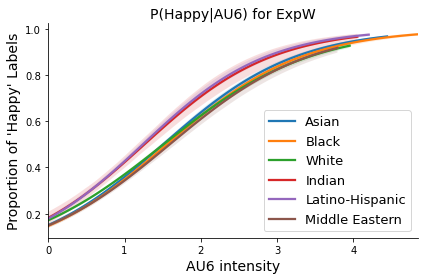

In [27]:
sns.lmplot(x='AU06_r', y='Happy', data=frame, hue = 'Race', logistic=True, scatter = False, hue_order = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern'], legend=False, height=4, aspect=6/4)
plt.legend(fontsize=13)
plt.xlabel("AU6 intensity", fontsize=14)
plt.ylabel("Proportion of 'Happy' Labels", fontsize=14)
plt.title('P(Happy|AU6) for ExpW', fontsize=14)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/ExpW_happy_6_AU6.pdf')
plt.show()

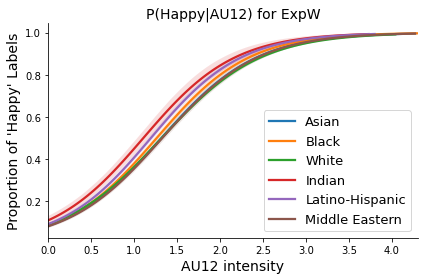

In [28]:
sns.lmplot(x='AU12_r', y='Happy', data=frame, hue = 'Race', logistic=True, scatter = False, hue_order = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern'], legend=False, height=4, aspect=6/4)
plt.legend(fontsize=13)
plt.xlabel("AU12 intensity", fontsize=14)
plt.ylabel("Proportion of 'Happy' Labels", fontsize=14)
plt.title('P(Happy|AU12) for ExpW', fontsize=14)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/ExpW_happy_6_AU12.pdf')
plt.show()

In [29]:
formula = 'Happy ~ AU06_r + AU12_r + Race'
model = smf.glm(formula = formula, data=frame, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Happy   No. Observations:                85355
Model:                            GLM   Df Residuals:                    85347
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38618.
Date:                Mon, 09 Aug 2021   Deviance:                       77236.
Time:                        17:19:03   Pearson chi2:                 8.35e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# RAF-DB

In [33]:
frame = pd.read_csv('RAFDB_OpenFace_result_with_Emotion_and_Gender_Age.csv')
print(frame.shape)
frame.head()

(12214, 55)


,ImageName,face,confidence,Emotion,Happy,Gender,AU01_c,AU02_c,AU04_c,AU05_c,...,AU06_r_c,AU09_r_c,AU10_r_c,AU12_r_c,AU15_r_c,AU17_r_c,AU20_r_c,AU25_r_c,AU26_r_c,Age
0,test_0001_aligned.jpg,0,0.925,5,0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2.0
1,test_0002_aligned.jpg,0,0.975,1,0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
2,test_0004_aligned.jpg,0,0.825,1,0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,2.0
3,test_0006_aligned.jpg,0,0.875,5,0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,2.0
4,test_0007_aligned.jpg,0,0.975,3,0,0.0,0.0,0.0,1.0,0.0,...,0,0,1,0,1,0,0,0,0,2.0


## Race Label

Notes:

In "train_XXXXX_manu_attri.txt" / "test_XXXX_manu_attri.txt", the first five lines contain location info (x, y) of 5 landmarks.
The next three lines presents information of gender, race and age attributes respectively:
	
Gender
    
0: male		1: female	2: unsure

Race	

0: Caucasian		1: African-American		2: Asian

Age (5 ranges)	

0: 0-3	 1: 4-19		2: 20-39		3: 40-69		4: 70+

In [34]:
from os import listdir
from os.path import isfile, join
mypath = 'RAF-DB/Basic_Emotion/Annotation/manual'
listdir(mypath)

['train_03396_manu_attri.txt',
 'train_04548_manu_attri.txt',
 'train_03383_manu_attri.txt',
 'test_0461_manu_attri.txt',
 'test_0474_manu_attri.txt',
 'train_11406_manu_attri.txt',
 'test_1490_manu_attri.txt',
 'train_11413_manu_attri.txt',
 'test_1485_manu_attri.txt',
 'train_06054_manu_attri.txt',
 'train_06041_manu_attri.txt',
 'test_2168_manu_attri.txt',
 'train_02367_manu_attri.txt',
 'train_08008_manu_attri.txt',
 'train_02372_manu_attri.txt',
 'train_00426_manu_attri.txt',
 'train_00433_manu_attri.txt',
 'test_0629_manu_attri.txt',
 'train_04715_manu_attri.txt',
 'train_04700_manu_attri.txt',
 'train_08255_manu_attri.txt',
 'train_08240_manu_attri.txt',
 'train_07900_manu_attri.txt',
 'test_2320_manu_attri.txt',
 'test_2335_manu_attri.txt',
 'train_07915_manu_attri.txt',
 'train_06209_manu_attri.txt',
 'train_09949_manu_attri.txt',
 'test_0075_manu_attri.txt',
 'test_0060_manu_attri.txt',
 'train_01966_manu_attri.txt',
 'train_01973_manu_attri.txt',
 'train_03782_manu_attri.txt

In [35]:
len(listdir(mypath))

15339

In [36]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
len(onlyfiles)

15339

In [37]:
for index, row in frame.iterrows():
    if index % 1000 == 0: print(index)
    name = row['ImageName'][:-12] + "_manu_attri.txt"
    myfile = open(mypath +"/" + name,"r") 
    frame.loc[index, "Race"] = int(myfile.readlines()[6][0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [38]:
frame

,ImageName,face,confidence,Emotion,Happy,Gender,AU01_c,AU02_c,AU04_c,AU05_c,...,AU09_r_c,AU10_r_c,AU12_r_c,AU15_r_c,AU17_r_c,AU20_r_c,AU25_r_c,AU26_r_c,Age,Race
0,test_0001_aligned.jpg,0,0.925,5,0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,2.0,2.0
1,test_0002_aligned.jpg,0,0.975,1,0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1.0,2.0
2,test_0004_aligned.jpg,0,0.825,1,0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,2.0,0.0
3,test_0006_aligned.jpg,0,0.875,5,0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,2.0,0.0
4,test_0007_aligned.jpg,0,0.975,3,0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,1,0,0,0,0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12209,train_12266_aligned.jpg,0,0.925,7,0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1.0,0.0
12210,train_12267_aligned.jpg,0,0.975,7,0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,0,1.0,1.0
12211,train_12268_aligned.jpg,0,0.875,7,0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,1,0,0,0,0,0.0,0.0
12212,train_12269_aligned.jpg,0,0.975,7,0,1.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1.0,0.0


In [39]:
frame.to_csv('RAFDB_OpenFace_result_with_Emotion_and_Gender_Age_Race.csv', index = False)

In [30]:
frame = pd.read_csv('RAFDB_OpenFace_result_with_Emotion_and_Gender_Age_Race.csv')

In [31]:
frame = frame.rename(columns={'Race': 'race_preds'})

In [32]:
frame.race_preds.value_counts()

0.0    9299
2.0    1904
1.0    1011
Name: race_preds, dtype: int64

In [33]:
def map_race(race):
    if race == 0:
        return "White"
    elif race == 1:
        return "Black"
    else:
        return "Asian"

frame['Race'] = frame.race_preds.apply(map_race)
frame.Race.value_counts()

White    9299
Asian    1904
Black    1011
Name: Race, dtype: int64

In [34]:
frame = frame.dropna()
frame.shape

(12214, 57)

In [35]:
frame['AU6and12_c'] = frame.AU06_c.apply(int).apply(str) + frame.AU12_c.apply(int).apply(str)
frame.AU6and12_c.value_counts()

11    6766
00    2619
10    1419
01    1410
Name: AU6and12_c, dtype: int64

In [36]:
frame['AU6and12_r_c'] = frame.AU06_r_c.apply(str) + frame.AU12_r_c.apply(str)
frame.AU6and12_r_c.value_counts()

00    8209
11    1881
01    1545
10     579
Name: AU6and12_r_c, dtype: int64

# P(expression|AU1, male) =? P(expression|AU1, female)

In [37]:
frame_0 = frame.loc[frame['race_preds'] == 0]
frame_1 = frame.loc[frame['race_preds'] == 1]
frame_2 = frame.loc[(frame['race_preds'] == 2)]
print(frame_0.shape)
print(frame_1.shape)
print(frame_2.shape)

(9299, 59)
(1011, 59)
(1904, 59)


In [38]:
frame_list = [frame_2, frame_1, frame_0]
name_list = ['Asian', 'Black', 'White']

## Happiness

In [39]:
for i in range(len(frame_list)):
    print(frame_list[i].Happy.mean(), name_list[i], frame_list[i].shape[0])

0.4028361344537815 Asian 1904
0.42136498516320475 Black 1011
0.375309173029358 White 9299


In [40]:
for i in range(len(frame_list)):
    print(frame_list[i].AU06_r_c.mean(), name_list[i], frame_list[i].shape[0])

0.21796218487394958 Asian 1904
0.17408506429277942 Black 1011
0.20098935369394558 White 9299


In [41]:
for i in range(len(frame_list)):
    print(frame_list[i].AU12_r_c.mean(), name_list[i], frame_list[i].shape[0])

0.28728991596638653 Asian 1904
0.27596439169139464 Black 1011
0.279599956984622 White 9299


In [42]:
for i in range(len(frame_list)):
    print(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index'), name_list[i], frame_list[i].shape[0])

Happy                0         1
AU6and12_r_c                    
00            0.799840  0.200160
01            0.116667  0.883333
10            0.657407  0.342593
11            0.127036  0.872964 Asian 1904
Happy                0         1
AU6and12_r_c                    
00            0.751085  0.248915
01            0.166667  0.833333
10            0.756098  0.243902
11            0.081481  0.918519 Black 1011
Happy                0         1
AU6and12_r_c                    
00            0.812889  0.187111
01            0.153316  0.846684
10            0.783721  0.216279
11            0.137596  0.862404 White 9299


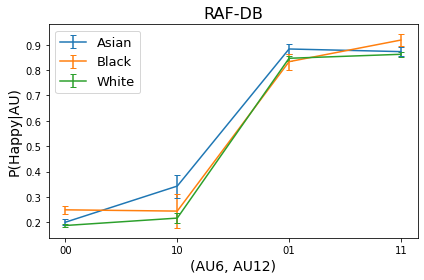

In [43]:
list_00 = []
list_01 = []
list_10 = []
list_11 = []

list_00_n = []
list_01_n = []
list_10_n = []
list_11_n = []

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
for i in range(len(frame_list)):
    list_00.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['00',1])
    list_01.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['01',1])
    list_10.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['10',1])
    list_11.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['11',1])
    
    list_00_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['00','All'])
    list_01_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['01','All'])
    list_10_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['10','All'])
    list_11_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['11','All'])
    
result_df = pd.DataFrame({"00": list_00, "10": list_10, "01": list_01, "11": list_11,
                         "00_n": list_00_n, "10_n": list_10_n, "01_n": list_01_n, "11_n": list_11_n}, index = name_list)
result_df['00_std'] = np.sqrt(result_df['00'] * (1-result_df['00']) / result_df['00_n'])
result_df['10_std'] = np.sqrt(result_df['10'] * (1-result_df['10']) / result_df['10_n'])
result_df['01_std'] = np.sqrt(result_df['01'] * (1-result_df['01']) / result_df['01_n'])
result_df['11_std'] = np.sqrt(result_df['11'] * (1-result_df['11']) / result_df['11_n'])
result_df
for index, row in result_df.iterrows():
    plt.errorbar(list(result_df.columns)[:4], list(row)[:4], yerr = list(row)[8:], label = index, capsize = 3)
plt.legend(fontsize = 13)
plt.xlabel('(AU6, AU12)', fontsize = 14)
plt.ylabel('P(Happy|AU)', fontsize = 14)
plt.title('RAF-DB', fontsize = 16)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_3_groups_graphs/RAFDB_happy_3_all.pdf')
plt.show()

In [44]:
for AU_comb in ['00','10', '01', '11']:
    print(AU_comb)
    combined_df = pd.DataFrame()
    for i in range(len(frame_list)):
        combined_df = combined_df.append(pd.crosstab(frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].race_preds, frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Happy))
    combined_df
    combined_df["row_totals"] = combined_df[0] + combined_df[1]
    combined_df.loc["col_totals"] = combined_df.sum()
    combined_df
    observed = combined_df.iloc[0:-1,0:-1]   # Get table without totals for later use

    expected =  np.outer(combined_df["row_totals"][0:-1],
                     combined_df.loc["col_totals"][0:-1]) / combined_df.loc['col_totals', 'row_totals']

    expected = pd.DataFrame(expected)
    expected.columns = [0,1]
    expected.index = combined_df.index[:-1]

    if (expected>=5).sum().sum() == (combined_df.shape[0]-1) * (combined_df.shape[1]-1):
        chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
        p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df= (combined_df.shape[0]-2) * (combined_df.shape[1]-2))
    else:
        chi_squared_stat = np.nan
        p_value = np.nan

    print(chi_squared_stat)
    print(p_value)
    print()

00
15.509432296552456
0.0004287158776632438

10
7.513389852561637
0.02336082216362445

01
2.5054211023412143
0.2857292624853065

11
3.469384730864441
0.17645447543373904



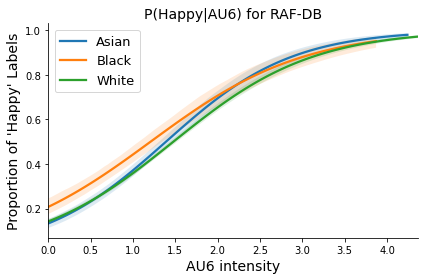

In [45]:
sns.lmplot(x='AU06_r', y='Happy', data=frame, hue = 'Race', logistic=True, scatter = False, hue_order = ['Asian', 'Black', 'White'], legend=False, height=4, aspect=6/4)
plt.legend(fontsize=13)
plt.xlabel("AU6 intensity", fontsize=14)
plt.ylabel("Proportion of 'Happy' Labels", fontsize=14)
plt.title('P(Happy|AU6) for RAF-DB', fontsize=14)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_3_groups_graphs/RAFDB_happy_3_AU6.pdf')
plt.show()

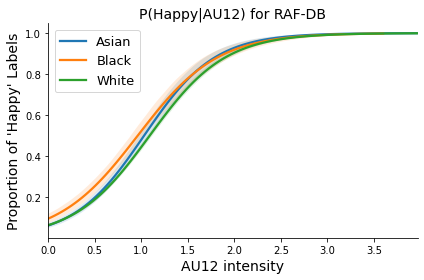

In [46]:
sns.lmplot(x='AU12_r', y='Happy', data=frame, hue = 'Race', logistic=True, scatter = False, hue_order = ['Asian', 'Black', 'White',], legend=False, height=4, aspect=6/4)
plt.legend(fontsize=13)
plt.xlabel("AU12 intensity", fontsize=14)
plt.ylabel("Proportion of 'Happy' Labels", fontsize=14)
plt.title('P(Happy|AU12) for RAF-DB', fontsize=14)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_3_groups_graphs/RAFDB_happy_3_AU12.pdf')
plt.show()

In [47]:
formula = 'Happy ~ AU06_r + AU12_r + Race'
model = smf.glm(formula = formula, data=frame, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Happy   No. Observations:                12214
Model:                            GLM   Df Residuals:                    12209
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4508.1
Date:                Mon, 09 Aug 2021   Deviance:                       9016.3
Time:                        17:19:41   Pearson chi2:                 1.17e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.3561      0.076    -30.801

# AffectNet Manual

In [48]:
frame = pd.read_csv('AffectNet_Manual_OpenFace_result_with_expression_gender_race_age.csv')
print(frame.shape)
frame.head()

(35694, 59)


,ImageName,Expression,Happy,race_preds,gender_preds,age_preds,race_scores,gender_scores,age_scores,face,...,AU05_r_c,AU06_r_c,AU09_r_c,AU10_r_c,AU12_r_c,AU15_r_c,AU17_r_c,AU20_r_c,AU25_r_c,AU26_r_c
0,0002074f0d5dafbb7983d509964312d04c612d9d425577...,10,0,White,Female,60-69,[0.425075 0.02112318 0.25978056 0.00382649 0...,[0.09870926 0.9012907 ],[5.3278323e-05 5.1294203e-04 3.1685282e-03 2.4...,0,...,0,0,0,1,0,0,0,0,1,0
1,000bdb0a8f54725d1424bb38d626b1d8bf17f001ad2406...,8,0,Black,Male,20-29,[3.52906886e-06 9.99552011e-01 1.59864125e-04 ...,[9.9954259e-01 4.5739944e-04],[5.6344652e-07 4.1122996e-05 1.3004625e-02 6.6...,0,...,0,1,0,1,1,0,0,0,1,0
2,000c10a8f6735212d71eb54298bc47ea56dc08e64ed2ca...,0,0,White,Male,40-49,[9.3397456e-01 4.9433287e-04 3.7014667e-02 4.5...,[0.99797386 0.00202617],[8.6898144e-05 1.5486187e-04 2.0614783e-03 2.4...,0,...,0,0,0,1,0,0,0,0,0,0
3,000fb19bfc2f4d09e33b30ae5d1be4488297e7ff6f0011...,1,1,White,Male,40-49,[9.3484497e-01 2.3674322e-05 1.4515205e-02 1.9...,[9.9999887e-01 1.1556698e-06],[3.4171117e-06 7.4146001e-06 5.2725355e-04 4.3...,0,...,0,0,0,1,1,0,0,0,0,0
4,0010aaaebcdd6bae8f967dc0e471760f7a45e220125be3...,1,1,Middle Eastern,Male,20-29,[4.4076398e-02 7.8236350e-05 4.0029038e-02 3.7...,[9.9999958e-01 3.9027404e-07],[5.4735474e-06 8.7598469e-03 4.4977888e-01 4.5...,0,...,0,1,0,1,1,0,0,0,1,0


In [49]:
frame.race_preds.value_counts()

White              23780
Latino_Hispanic     3179
Black               2833
Middle Eastern      2532
East Asian          1524
Indian              1159
Southeast Asian      687
Name: race_preds, dtype: int64

In [50]:
# race label
frame.loc[frame['race_preds'] == 'White', 'race'] = 0
frame.loc[frame['race_preds'] == 'Black', 'race'] = 1
frame.loc[frame['race_preds'] == 'Latino_Hispanic', 'race'] = 2
frame.loc[frame['race_preds'] == 'East Asian', 'race'] = 3
frame.loc[frame['race_preds'] == 'Southeast Asian', 'race'] = 4
frame.loc[frame['race_preds'] == 'Indian', 'race'] = 5
frame.loc[frame['race_preds'] == 'Middle Eastern', 'race'] = 6
frame.race.value_counts()

0.0    23780
2.0     3179
1.0     2833
6.0     2532
3.0     1524
5.0     1159
4.0      687
Name: race, dtype: int64

In [51]:
frame['Race'] = frame['race_preds'].apply(lambda x: x if x != 'East Asian' and x != 'Southeast Asian' else 'Asian')
frame['Race'] = frame['Race'].apply(lambda x: x if x != 'Latino_Hispanic' else 'Latino-Hispanic')
frame.Race.value_counts()

White              23780
Latino-Hispanic     3179
Black               2833
Middle Eastern      2532
Asian               2211
Indian              1159
Name: Race, dtype: int64

In [52]:
frame = frame.dropna()
frame.shape

(35694, 61)

In [53]:
frame['AU6and12_c'] = frame.AU06_c.apply(int).apply(str) + frame.AU12_c.apply(int).apply(str)
frame.AU6and12_c.value_counts()

00    15395
11    12018
10     4277
01     4004
Name: AU6and12_c, dtype: int64

In [54]:
frame['AU6and12_r_c'] = frame.AU06_r_c.apply(str) + frame.AU12_r_c.apply(str)
frame.AU6and12_r_c.value_counts()

00    23289
01     6111
11     5431
10      863
Name: AU6and12_r_c, dtype: int64

In [55]:
print(list(frame.columns))

['ImageName', 'Expression', 'Happy', 'race_preds', 'gender_preds', 'age_preds', 'race_scores', 'gender_scores', 'age_scores', 'face', 'confidence', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_r_c', 'AU02_r_c', 'AU04_r_c', 'AU05_r_c', 'AU06_r_c', 'AU09_r_c', 'AU10_r_c', 'AU12_r_c', 'AU15_r_c', 'AU17_r_c', 'AU20_r_c', 'AU25_r_c', 'AU26_r_c', 'race', 'Race', 'AU6and12_c', 'AU6and12_r_c']


In [56]:
frame_0 = frame.loc[frame['race'] == 0]
frame_1 = frame.loc[frame['race'] == 1]
frame_2 = frame.loc[(frame['race'] == 3) | (frame['race'] == 4)]
frame_3 = frame.loc[frame['race'] == 5]
frame_4 = frame.loc[frame['race'] == 2]
frame_5 = frame.loc[frame['race'] == 6]
print(frame_0.shape)
print(frame_1.shape)
print(frame_2.shape)
print(frame_3.shape)
print(frame_4.shape)
print(frame_5.shape)

(23780, 63)
(2833, 63)
(2211, 63)
(1159, 63)
(3179, 63)
(2532, 63)


In [57]:
frame_list = [frame_2, frame_1, frame_0, frame_3, frame_4, frame_5]
name_list = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern']

# P(expression|AU1, male) =? P(expression|AU1, female)

## Happiness

In [58]:
for i in range(len(frame_list)):
    print(frame_list[i].Happy.mean(), name_list[i], frame_list[i].shape[0])

0.310719131614654 Asian 2211
0.3201553123896929 Black 2833
0.3203111858704794 White 23780
0.3114754098360656 Indian 1159
0.3211701793016672 Latino-Hispanic 3179
0.22195892575039494 Middle Eastern 2532


In [59]:
for i in range(len(frame_list)):
    print(frame_list[i].AU06_r_c.mean(), name_list[i], frame_list[i].shape[0])

0.18860244233378562 Asian 2211
0.20684786445464173 Black 2833
0.1776282590412111 White 23780
0.18550474547023296 Indian 1159
0.19282793331236237 Latino-Hispanic 3179
0.09439178515007898 Middle Eastern 2532


In [60]:
for i in range(len(frame_list)):
    print(frame_list[i].AU12_r_c.mean(), name_list[i], frame_list[i].shape[0])

0.3437358661239258 Asian 2211
0.337451464878221 Black 2833
0.3279226240538268 White 23780
0.32269197584124243 Indian 1159
0.3302925448254168 Latino-Hispanic 3179
0.23854660347551343 Middle Eastern 2532


In [61]:
for i in range(len(frame_list)):
    print(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index'), name_list[i], frame_list[i].shape[0])

Happy                0         1
AU6and12_r_c                    
00            0.905916  0.094084
01            0.342711  0.657289
10            0.791667  0.208333
11            0.219512  0.780488 Asian 2211
Happy                0         1
AU6and12_r_c                    
00            0.917084  0.082916
01            0.306667  0.693333
10            0.725000  0.275000
11            0.162055  0.837945 Black 2833
Happy                0         1
AU6and12_r_c                    
00            0.893809  0.106191
01            0.316872  0.683128
10            0.734291  0.265709
11            0.179438  0.820562 White 23780
Happy                0         1
AU6and12_r_c                    
00            0.901333  0.098667
01            0.319588  0.680412
10            0.771429  0.228571
11            0.183333  0.816667 Indian 1159
Happy                0         1
AU6and12_r_c                    
00            0.896282  0.103718
01            0.319923  0.680077
10            0.788235  0.2117

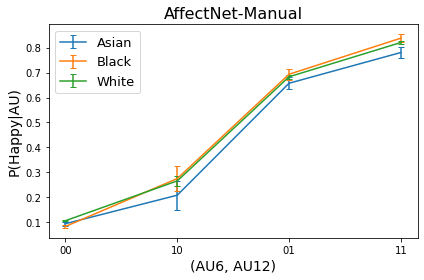

In [62]:
list_00 = []
list_01 = []
list_10 = []
list_11 = []

list_00_n = []
list_01_n = []
list_10_n = []
list_11_n = []

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
for i in range(len(frame_list)-3):
    list_00.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['00',1])
    list_01.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['01',1])
    list_10.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['10',1])
    list_11.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['11',1])
    
    list_00_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['00','All'])
    list_01_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['01','All'])
    list_10_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['10','All'])
    list_11_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['11','All'])
    
result_df = pd.DataFrame({"00": list_00, "10": list_10, "01": list_01, "11": list_11,
                         "00_n": list_00_n, "10_n": list_10_n, "01_n": list_01_n, "11_n": list_11_n}, index = name_list[:-3])
result_df['00_std'] = np.sqrt(result_df['00'] * (1-result_df['00']) / result_df['00_n'])
result_df['10_std'] = np.sqrt(result_df['10'] * (1-result_df['10']) / result_df['10_n'])
result_df['01_std'] = np.sqrt(result_df['01'] * (1-result_df['01']) / result_df['01_n'])
result_df['11_std'] = np.sqrt(result_df['11'] * (1-result_df['11']) / result_df['11_n'])
result_df
for index, row in result_df.iterrows():
    plt.errorbar(list(result_df.columns)[:4], list(row)[:4], yerr = list(row)[8:], label = index, capsize = 3)
plt.legend(fontsize = 13)
plt.xlabel('(AU6, AU12)', fontsize = 14)
plt.ylabel('P(Happy|AU)', fontsize = 14)
plt.title('AffectNet-Manual', fontsize = 16)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_3_groups_graphs/AffectNet_Manual_happy_3_all.pdf')
plt.show()

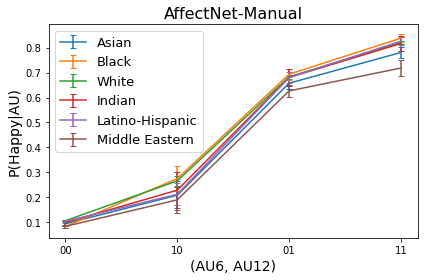

In [63]:
list_00 = []
list_01 = []
list_10 = []
list_11 = []

list_00_n = []
list_01_n = []
list_10_n = []
list_11_n = []

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
for i in range(len(frame_list)):
    list_00.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['00',1])
    list_01.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['01',1])
    list_10.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['10',1])
    list_11.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['11',1])
    
    list_00_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['00','All'])
    list_01_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['01','All'])
    list_10_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['10','All'])
    list_11_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['11','All'])
    
result_df = pd.DataFrame({"00": list_00, "10": list_10, "01": list_01, "11": list_11,
                         "00_n": list_00_n, "10_n": list_10_n, "01_n": list_01_n, "11_n": list_11_n}, index = name_list)
result_df['00_std'] = np.sqrt(result_df['00'] * (1-result_df['00']) / result_df['00_n'])
result_df['10_std'] = np.sqrt(result_df['10'] * (1-result_df['10']) / result_df['10_n'])
result_df['01_std'] = np.sqrt(result_df['01'] * (1-result_df['01']) / result_df['01_n'])
result_df['11_std'] = np.sqrt(result_df['11'] * (1-result_df['11']) / result_df['11_n'])
result_df
for index, row in result_df.iterrows():
    plt.errorbar(list(result_df.columns)[:4], list(row)[:4], yerr = list(row)[8:], label = index, capsize = 3)
plt.legend(fontsize = 13)
plt.xlabel('(AU6, AU12)', fontsize = 14)
plt.ylabel('P(Happy|AU)', fontsize = 14)
plt.title('AffectNet-Manual', fontsize = 16)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/AffectNet_Manual_happy_6_all.pdf')
plt.show()

In [64]:
for AU_comb in ['00','10', '01', '11']:
    print(AU_comb)
    combined_df = pd.DataFrame()
    for i in range(len(frame_list)):
        combined_df = combined_df.append(pd.crosstab(frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Race, frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Happy))
    combined_df
    combined_df["row_totals"] = combined_df[0] + combined_df[1]
    combined_df.loc["col_totals"] = combined_df.sum()
    combined_df
    observed = combined_df.iloc[0:-1,0:-1]   # Get table without totals for later use

    expected =  np.outer(combined_df["row_totals"][0:-1],
                     combined_df.loc["col_totals"][0:-1]) / combined_df.loc['col_totals', 'row_totals']

    expected = pd.DataFrame(expected)
    expected.columns = [0,1]
    expected.index = combined_df.index[:-1]

    if (expected>=5).sum().sum() == (combined_df.shape[0]-1) * (combined_df.shape[1]-1):
        chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
        p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df= (combined_df.shape[0]-2) * (combined_df.shape[1]-2))
    else:
        chi_squared_stat = np.nan
        p_value = np.nan

    print(chi_squared_stat)
    print(p_value)
    print()

00
18.2665498361765
0.002630243109257191

10
3.296748208038654
0.6543395668530865

01
6.908681400540738
0.2275208652921591

11
17.11291317695868
0.0042905582114944885



In [65]:
# p-value for testing the three major races only
for AU_comb in ['00','10', '01', '11']:
    print(AU_comb)
    combined_df = pd.DataFrame()
    for i in range(3):
        combined_df = combined_df.append(pd.crosstab(frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Race, frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Happy))
    combined_df
    combined_df["row_totals"] = combined_df[0] + combined_df[1]
    combined_df.loc["col_totals"] = combined_df.sum()
    combined_df
    observed = combined_df.iloc[0:-1,0:-1]   # Get table without totals for later use

    expected =  np.outer(combined_df["row_totals"][0:-1],
                     combined_df.loc["col_totals"][0:-1]) / combined_df.loc['col_totals', 'row_totals']
    
    expected = pd.DataFrame(expected)
    expected.columns = [0,1]
    expected.index = combined_df.index[:-1]
    
    if (expected>=5).sum().sum() == (combined_df.shape[0]-1) * (combined_df.shape[1]-1):
        chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
        p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df= (combined_df.shape[0]-2) * (combined_df.shape[1]-2))
    else:
        chi_squared_stat = np.nan
        p_value = np.nan

    print(chi_squared_stat)
    print(p_value)
    print()

00
10.74956888228736
0.004631917076676095

10
0.820851462764469
0.6633677735318528

01
1.3916607438886481
0.49866020257808474

11
4.980798002641102
0.08287689198786319



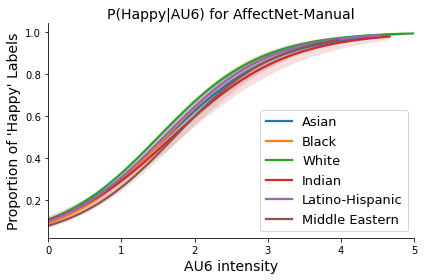

In [66]:
sns.lmplot(x='AU06_r', y='Happy', data=frame, hue = 'Race', logistic=True, scatter = False, hue_order = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern'], legend=False, height=4, aspect=6/4)
plt.legend(fontsize=13)
plt.xlabel("AU6 intensity", fontsize=14)
plt.ylabel("Proportion of 'Happy' Labels", fontsize=14)
plt.title('P(Happy|AU6) for AffectNet-Manual', fontsize=14)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/AffectNet_Manual_happy_6_AU6.pdf')
plt.show()

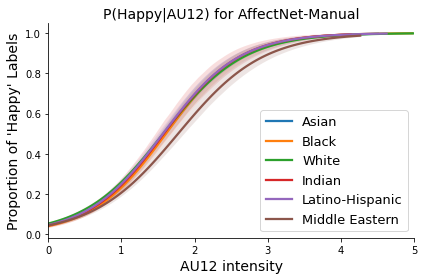

In [67]:
sns.lmplot(x='AU12_r', y='Happy', data=frame, hue = 'Race', logistic=True, scatter = False, hue_order = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern'], legend=False, height=4, aspect=6/4)
plt.legend(fontsize=13)
plt.xlabel("AU12 intensity", fontsize=14)
plt.ylabel("Proportion of 'Happy' Labels", fontsize=14)
plt.title('P(Happy|AU12) for AffectNet-Manual', fontsize=14)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/AffectNet_Manual_happy_6_AU12.pdf')
plt.show()

In [68]:
formula = 'Happy ~ AU06_r + AU12_r + Race'
model = smf.glm(formula = formula, data=frame, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Happy   No. Observations:                35694
Model:                            GLM   Df Residuals:                    35686
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12906.
Date:                Mon, 09 Aug 2021   Deviance:                       25812.
Time:                        17:21:04   Pearson chi2:                 3.65e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# AffectNet Automatic

In [69]:
frame = pd.read_csv('AffectNet_Automatic_OpenFace_result_with_expression_gender_race_age.csv')
print(frame.shape)
frame.head()

(42284, 59)


,ImageName,Expression,Happy,race_preds,gender_preds,age_preds,race_scores,gender_scores,age_scores,face,...,AU05_r_c,AU06_r_c,AU09_r_c,AU10_r_c,AU12_r_c,AU15_r_c,AU17_r_c,AU20_r_c,AU25_r_c,AU26_r_c
0,0000278c7363d43c42a4db994a51e36aad351f55e77680...,10,0,White,Female,40-49,[9.7449505e-01 5.2814976e-06 5.5093807e-03 4.6...,[7.1670633e-04 9.9928331e-01],[2.2580596e-07 1.7767234e-06 2.0319392e-04 2.8...,0,...,0,0,0,1,0,0,0,0,1,0
1,0000fa4e4ffdc2a6042a0eadf8a2d067774705ba17721a...,10,0,East Asian,Female,20-29,[1.9185199e-01 7.3396941e-06 1.9742842e-03 7.8...,[6.5521155e-05 9.9993443e-01],[1.48235313e-06 3.44420609e-04 2.11575143e-02 ...,0,...,0,0,0,0,0,0,0,0,1,0
2,00017248a05758584faf54d4ccdb23d5365a5bfc3e3aee...,0,0,Black,Female,30-39,[2.06290515e-05 9.99178529e-01 1.19858145e-04 ...,[0.00982992 0.9901701 ],[1.80382315e-07 2.75580824e-05 3.95781221e-03 ...,0,...,0,0,0,0,0,0,0,0,0,0
3,000364dc26143c95e73e8dca30c0f3730db84c295c0b48...,1,1,East Asian,Female,20-29,[9.0016201e-03 2.3799853e-06 2.5050717e-03 9.5...,[6.7393144e-06 9.9999321e-01],[1.0476051e-07 6.7055156e-04 1.7963018e-01 8.1...,0,...,0,0,0,0,1,0,0,0,0,0
4,0003a7c1e380e87c864436434115f656c92b695e384f88...,10,0,White,Female,20-29,[0.60690844 0.01389638 0.2529639 0.00064708 0...,[0.00108382 0.9989162 ],[9.6977169e-07 3.5300865e-04 4.1254394e-02 6.1...,0,...,0,0,0,1,0,1,0,0,0,0


In [70]:
frame.race_preds.value_counts()

White              26798
Black               4454
Latino_Hispanic     3198
Middle Eastern      2667
East Asian          2545
Indian              1548
Southeast Asian     1074
Name: race_preds, dtype: int64

In [71]:
# race label
frame.loc[frame['race_preds'] == 'White', 'race'] = 0
frame.loc[frame['race_preds'] == 'Black', 'race'] = 1
frame.loc[frame['race_preds'] == 'Latino_Hispanic', 'race'] = 2
frame.loc[frame['race_preds'] == 'East Asian', 'race'] = 3
frame.loc[frame['race_preds'] == 'Southeast Asian', 'race'] = 4
frame.loc[frame['race_preds'] == 'Indian', 'race'] = 5
frame.loc[frame['race_preds'] == 'Middle Eastern', 'race'] = 6
frame.race.value_counts()

0.0    26798
1.0     4454
2.0     3198
6.0     2667
3.0     2545
5.0     1548
4.0     1074
Name: race, dtype: int64

In [72]:
frame['Race'] = frame['race_preds'].apply(lambda x: x if x != 'East Asian' and x != 'Southeast Asian' else 'Asian')
frame['Race'] = frame['Race'].apply(lambda x: x if x != 'Latino_Hispanic' else 'Latino-Hispanic')
frame.Race.value_counts()

White              26798
Black               4454
Asian               3619
Latino-Hispanic     3198
Middle Eastern      2667
Indian              1548
Name: Race, dtype: int64

In [73]:
frame = frame.dropna()
frame.shape

(42284, 61)

In [74]:
frame['AU6and12_c'] = frame.AU06_c.apply(int).apply(str) + frame.AU12_c.apply(int).apply(str)
frame.AU6and12_c.value_counts()

00    18398
11    14291
01     5093
10     4502
Name: AU6and12_c, dtype: int64

In [75]:
frame['AU6and12_r_c'] = frame.AU06_r_c.apply(str) + frame.AU12_r_c.apply(str)
frame.AU6and12_r_c.value_counts()

00    27828
01     7198
11     6392
10      866
Name: AU6and12_r_c, dtype: int64

In [76]:
print(list(frame.columns))

['ImageName', 'Expression', 'Happy', 'race_preds', 'gender_preds', 'age_preds', 'race_scores', 'gender_scores', 'age_scores', 'face', 'confidence', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_r_c', 'AU02_r_c', 'AU04_r_c', 'AU05_r_c', 'AU06_r_c', 'AU09_r_c', 'AU10_r_c', 'AU12_r_c', 'AU15_r_c', 'AU17_r_c', 'AU20_r_c', 'AU25_r_c', 'AU26_r_c', 'race', 'Race', 'AU6and12_c', 'AU6and12_r_c']


In [77]:
frame_0 = frame.loc[frame['race'] == 0]
frame_1 = frame.loc[frame['race'] == 1]
frame_2 = frame.loc[(frame['race'] == 3) | (frame['race'] == 4)]
frame_3 = frame.loc[frame['race'] == 5]
frame_4 = frame.loc[frame['race'] == 2]
frame_5 = frame.loc[frame['race'] == 6]
print(frame_0.shape)
print(frame_1.shape)
print(frame_2.shape)
print(frame_3.shape)
print(frame_4.shape)
print(frame_5.shape)

(26798, 63)
(4454, 63)
(3619, 63)
(1548, 63)
(3198, 63)
(2667, 63)


In [78]:
frame_list = [frame_2, frame_1, frame_0, frame_3, frame_4, frame_5]
name_list = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern']

# P(expression|AU1, male) =? P(expression|AU1, female)

## Happiness

In [79]:
for i in range(len(frame_list)):
    print(frame_list[i].Happy.mean(), name_list[i], frame_list[i].shape[0])

0.4266371925946394 Asian 3619
0.3911091154018859 Black 4454
0.4295469811179939 White 26798
0.4024547803617571 Indian 1548
0.4530956848030019 Latino-Hispanic 3198
0.28046494188226473 Middle Eastern 2667


In [80]:
for i in range(len(frame_list)):
    print(frame_list[i].AU06_r_c.mean(), name_list[i], frame_list[i].shape[0])

0.1831997789444598 Asian 3619
0.17669510552312528 Black 4454
0.1747518471527726 White 26798
0.19896640826873385 Indian 1548
0.18386491557223264 Latino-Hispanic 3198
0.08586426696662917 Middle Eastern 2667


In [81]:
for i in range(len(frame_list)):
    print(frame_list[i].AU12_r_c.mean(), name_list[i], frame_list[i].shape[0])

0.3348991434097817 Asian 3619
0.31769196228109564 Black 4454
0.33133069632062095 White 26798
0.3184754521963824 Indian 1548
0.3433395872420263 Latino-Hispanic 3198
0.18485189351331083 Middle Eastern 2667


In [82]:
for i in range(len(frame_list)):
    print(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index'), name_list[i], frame_list[i].shape[0])

Happy                0         1
AU6and12_r_c                    
00            0.792751  0.207249
01            0.171849  0.828151
10            0.564516  0.435484
11            0.126456  0.873544 Asian 3619
Happy                0         1
AU6and12_r_c                    
00            0.845945  0.154055
01            0.152778  0.847222
10            0.565217  0.434783
11            0.082014  0.917986 Black 4454
Happy                0         1
AU6and12_r_c                    
00            0.806604  0.193396
01            0.146692  0.853308
10            0.527103  0.472897
11            0.069672  0.930328 White 26798
Happy                0         1
AU6and12_r_c                    
00            0.824284  0.175716
01            0.162996  0.837004
10            0.738095  0.261905
11            0.082707  0.917293 Indian 1548
Happy                0         1
AU6and12_r_c                    
00            0.795624  0.204376
01            0.115192  0.884808
10            0.516854  0.4831

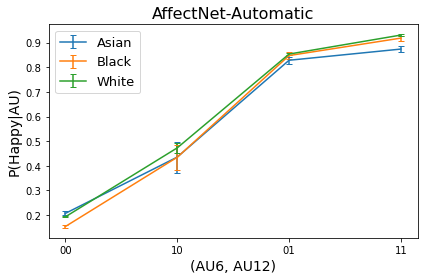

In [83]:
list_00 = []
list_01 = []
list_10 = []
list_11 = []

list_00_n = []
list_01_n = []
list_10_n = []
list_11_n = []

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
for i in range(len(frame_list)-3):
    list_00.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['00',1])
    list_01.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['01',1])
    list_10.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['10',1])
    list_11.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['11',1])
    
    list_00_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['00','All'])
    list_01_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['01','All'])
    list_10_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['10','All'])
    list_11_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['11','All'])
    
result_df = pd.DataFrame({"00": list_00, "10": list_10, "01": list_01, "11": list_11,
                         "00_n": list_00_n, "10_n": list_10_n, "01_n": list_01_n, "11_n": list_11_n}, index = name_list[:-3])
result_df['00_std'] = np.sqrt(result_df['00'] * (1-result_df['00']) / result_df['00_n'])
result_df['10_std'] = np.sqrt(result_df['10'] * (1-result_df['10']) / result_df['10_n'])
result_df['01_std'] = np.sqrt(result_df['01'] * (1-result_df['01']) / result_df['01_n'])
result_df['11_std'] = np.sqrt(result_df['11'] * (1-result_df['11']) / result_df['11_n'])
result_df
for index, row in result_df.iterrows():
    plt.errorbar(list(result_df.columns)[:4], list(row)[:4], yerr = list(row)[8:], label = index, capsize = 3)
plt.legend(fontsize = 13)
plt.xlabel('(AU6, AU12)', fontsize = 14)
plt.ylabel('P(Happy|AU)', fontsize = 14)
plt.title('AffectNet-Automatic', fontsize = 16)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_3_groups_graphs/AffectNet_Automatic_happy_3_all.pdf')
plt.show()

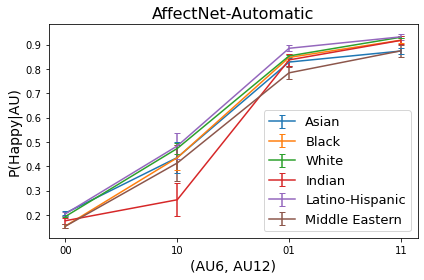

In [84]:
list_00 = []
list_01 = []
list_10 = []
list_11 = []

list_00_n = []
list_01_n = []
list_10_n = []
list_11_n = []

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
for i in range(len(frame_list)):
    list_00.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['00',1])
    list_01.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['01',1])
    list_10.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['10',1])
    list_11.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, normalize = 'index').loc['11',1])
    
    list_00_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['00','All'])
    list_01_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['01','All'])
    list_10_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['10','All'])
    list_11_n.append(pd.crosstab(frame_list[i].AU6and12_r_c, frame_list[i].Happy, margins = True).loc['11','All'])
    
result_df = pd.DataFrame({"00": list_00, "10": list_10, "01": list_01, "11": list_11,
                         "00_n": list_00_n, "10_n": list_10_n, "01_n": list_01_n, "11_n": list_11_n}, index = name_list)
result_df['00_std'] = np.sqrt(result_df['00'] * (1-result_df['00']) / result_df['00_n'])
result_df['10_std'] = np.sqrt(result_df['10'] * (1-result_df['10']) / result_df['10_n'])
result_df['01_std'] = np.sqrt(result_df['01'] * (1-result_df['01']) / result_df['01_n'])
result_df['11_std'] = np.sqrt(result_df['11'] * (1-result_df['11']) / result_df['11_n'])
result_df
for index, row in result_df.iterrows():
    plt.errorbar(list(result_df.columns)[:4], list(row)[:4], yerr = list(row)[8:], label = index, capsize = 3)
plt.legend(fontsize = 13)
plt.xlabel('(AU6, AU12)', fontsize = 14)
plt.ylabel('P(Happy|AU)', fontsize = 14)
plt.title('AffectNet-Automatic', fontsize = 16)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/AffectNet_Automatic_happy_6_all.pdf')
plt.show()

In [85]:
for AU_comb in ['00','10', '01', '11']:
    print(AU_comb)
    combined_df = pd.DataFrame()
    for i in range(len(frame_list)):
        combined_df = combined_df.append(pd.crosstab(frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Race, frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Happy))
    combined_df
    combined_df["row_totals"] = combined_df[0] + combined_df[1]
    combined_df.loc["col_totals"] = combined_df.sum()
    combined_df
    observed = combined_df.iloc[0:-1,0:-1]   # Get table without totals for later use

    expected =  np.outer(combined_df["row_totals"][0:-1],
                     combined_df.loc["col_totals"][0:-1]) / combined_df.loc['col_totals', 'row_totals']

    expected = pd.DataFrame(expected)
    expected.columns = [0,1]
    expected.index = combined_df.index[:-1]

    if (expected>=5).sum().sum() == (combined_df.shape[0]-1) * (combined_df.shape[1]-1):
        chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
        p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df= (combined_df.shape[0]-2) * (combined_df.shape[1]-2))
    else:
        chi_squared_stat = np.nan
        p_value = np.nan

    print(chi_squared_stat)
    print(p_value)
    print()

00
52.7355772090832
3.811124749120154e-10

10
7.862472342519396
0.16397969350980968

01
19.32305379828043
0.0016731569560306525

11
30.173578571944404
1.363250194441612e-05



In [86]:
# p-value for testing the three major races only
for AU_comb in ['00','10', '01', '11']:
    print(AU_comb)
    combined_df = pd.DataFrame()
    for i in range(3):
        combined_df = combined_df.append(pd.crosstab(frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Race, frame_list[i][frame_list[i].AU6and12_r_c == AU_comb].Happy))
    combined_df
    combined_df["row_totals"] = combined_df[0] + combined_df[1]
    combined_df.loc["col_totals"] = combined_df.sum()
    combined_df
    observed = combined_df.iloc[0:-1,0:-1]   # Get table without totals for later use

    expected =  np.outer(combined_df["row_totals"][0:-1],
                     combined_df.loc["col_totals"][0:-1]) / combined_df.loc['col_totals', 'row_totals']

    expected = pd.DataFrame(expected)
    expected.columns = [0,1]
    expected.index = combined_df.index[:-1]

    if (expected>=5).sum().sum() == (combined_df.shape[0]-1) * (combined_df.shape[1]-1):
        chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()
        p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df= (combined_df.shape[0]-2) * (combined_df.shape[1]-2))
    else:
        chi_squared_stat = np.nan
        p_value = np.nan

    print(chi_squared_stat)
    print(p_value)
    print()

00
30.60086268967924
2.265202833084956e-07

10
0.6881580523439896
0.708872906323731

01
2.738001009541898
0.25436106521408597

11
23.895860396770388
6.472616033148526e-06



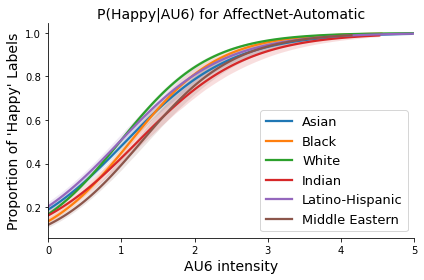

In [87]:
sns.lmplot(x='AU06_r', y='Happy', data=frame, hue = 'Race', logistic=True, scatter = False, hue_order = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern'], legend=False, height=4, aspect=6/4)
plt.legend(fontsize=13)
plt.xlabel("AU6 intensity", fontsize=14)
plt.ylabel("Proportion of 'Happy' Labels", fontsize=14)
plt.title('P(Happy|AU6) for AffectNet-Automatic', fontsize=14)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/AffectNet_Automatic_happy_6_AU6.pdf')
plt.show()

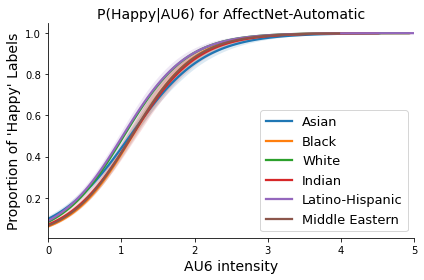

In [88]:
sns.lmplot(x='AU12_r', y='Happy', data=frame, hue = 'Race', logistic=True, scatter = False, hue_order = ['Asian', 'Black', 'White', 'Indian', 'Latino-Hispanic', 'Middle Eastern'], legend=False, height=4, aspect=6/4)
plt.legend(fontsize=13)
plt.xlabel("AU6 intensity", fontsize=14)
plt.ylabel("Proportion of 'Happy' Labels", fontsize=14)
plt.title('P(Happy|AU6) for AffectNet-Automatic', fontsize=14)
plt.tight_layout()
plt.savefig('age_race_bias_plots/race_6_groups_graphs/AffectNet_Automatic_happy_6_AU12.pdf')
plt.show()

In [89]:
formula = 'Happy ~ AU06_r + AU12_r + Race'
model = smf.glm(formula = formula, data=frame, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Happy   No. Observations:                42284
Model:                            GLM   Df Residuals:                    42276
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15511.
Date:                Mon, 09 Aug 2021   Deviance:                       31022.
Time:                        17:22:42   Pearson chi2:                 7.08e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# KDEF

In [163]:
frame = pd.read_csv('KDEF_OpenFace_result_with_Emotion_and_Gender.csv')
print(frame.shape)
frame.head()

(2926, 54)


,ImageName,face,confidence,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,...,AU10_r_c,AU12_r_c,AU15_r_c,AU17_r_c,AU20_r_c,AU25_r_c,AU26_r_c,Emotion,Happy,Gender
0,AF01AFHL.jpg,0,0.475,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,AF,0,F
1,AF01AFHR.jpg,0,0.975,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1,1,0,0,0,1,0,AF,0,F
2,AF01AFS.jpg,0,0.975,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1,1,0,0,0,1,0,AF,0,F
3,AF01ANHL.jpg,0,0.425,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,AN,0,F
4,AF01ANHR.jpg,0,0.575,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1,0,0,0,0,1,0,AN,0,F


In [164]:
frame = frame[frame.ImageName.apply(lambda x: x[6] == 'S')]
frame.shape

(974, 54)

In [165]:
print(list(frame.columns))

['ImageName', 'face', 'confidence', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_r_c', 'AU02_r_c', 'AU04_r_c', 'AU05_r_c', 'AU06_r_c', 'AU09_r_c', 'AU10_r_c', 'AU12_r_c', 'AU15_r_c', 'AU17_r_c', 'AU20_r_c', 'AU25_r_c', 'AU26_r_c', 'Emotion', 'Happy', 'Gender']


In [176]:
frame = frame.dropna()
frame.shape

(974, 54)

KDEF does not have race information.

# Chicago Face

In [166]:
frame = pd.read_csv('ChicagoFace_with_AU_cleanedup.csv')
print(frame.shape)
frame.head()

(1207, 54)


,ImageName,Gender,Race,Expression,face,confidence,AU01_r,AU02_r,AU04_r,AU05_r,...,AU05_r_c,AU06_r_c,AU09_r_c,AU10_r_c,AU12_r_c,AU15_r_c,AU17_r_c,AU20_r_c,AU25_r_c,AU26_r_c
0,CFD-WM-239-128-N.jpg,M,W,Neutral,0,0.975,0.00,0.00,0.49,0.00,...,0,0,0,1,0,0,0,0,1,0
1,CFD-BM-219-141-N.jpg,M,B,Neutral,0,0.975,1.69,1.28,0.00,0.36,...,0,0,0,0,0,1,0,0,1,0
2,CFD-WF-034-016-A.jpg,F,W,Angry,0,0.975,1.30,0.02,1.70,2.03,...,0,0,0,1,0,0,0,0,0,0
3,CFD-BM-030-065-F.jpg,M,B,Fear,0,0.975,2.90,4.65,0.00,2.64,...,0,0,0,1,1,0,0,0,1,0
4,CFD-LM-237-264-N.jpg,M,L,Neutral,0,0.975,1.01,0.21,1.05,0.13,...,0,0,0,1,0,0,0,0,0,0


In [167]:
frame.Race.value_counts()

B    526
W    464
A    109
L    108
Name: Race, dtype: int64

In [171]:
def map_race(race):
    if race == "B":
        return "Black"
    elif race == "W":
        return "White"
    elif race == "A":
        return "Asian"
    else:
        return "Latino-Hispanic"

frame['Race'] = frame.Race.apply(map_race)
frame.Race.value_counts()

Black              526
White              464
Asian              109
Latino-Hispanic    108
Name: Race, dtype: int64

In [172]:
# race label
frame.loc[frame['Race'] == 'White', 'race'] = 0
frame.loc[frame['Race'] == 'Black', 'race'] = 1
frame.loc[frame['Race'] == 'Latino-Hispanic', 'race'] = 2
frame.loc[frame['Race'] == 'Asian', 'race'] = 3
frame.race.value_counts()

1.0    526
0.0    464
3.0    109
2.0    108
Name: race, dtype: int64

In [175]:
print(list(frame.columns))

['ImageName', 'Gender', 'Race', 'Expression', 'face', 'confidence', 'AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'AU01_r_c', 'AU02_r_c', 'AU04_r_c', 'AU05_r_c', 'AU06_r_c', 'AU09_r_c', 'AU10_r_c', 'AU12_r_c', 'AU15_r_c', 'AU17_r_c', 'AU20_r_c', 'AU25_r_c', 'AU26_r_c', 'race_preds', 'race']


In [176]:
frame['Angry'] = (frame['Expression'] =='Angry').astype(int)
frame['Fear'] = (frame['Expression'] == 'Fear').astype(int)
frame['Happy'] = (frame['Expression'] =='Happy').astype(int)
frame['Neutral'] = (frame['Expression'] == 'Neutral').astype(int)

In [177]:
frame = frame.dropna()
frame.shape

(1207, 60)

In [178]:
frame['AU6and12_c'] = frame.AU06_c.apply(int).apply(str) + frame.AU12_c.apply(int).apply(str)
frame.AU6and12_c.value_counts()

00    650
11    345
01    158
10     54
Name: AU6and12_c, dtype: int64

In [179]:
frame['AU6and12_r_c'] = frame.AU06_r_c.apply(str) + frame.AU12_r_c.apply(str)
frame.AU6and12_r_c.value_counts()

00    784
11    274
01    136
10     13
Name: AU6and12_r_c, dtype: int64

CFD has too few data for race analysis.